# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


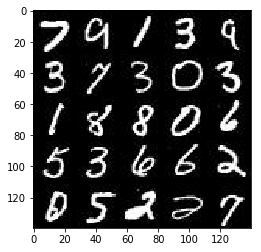

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

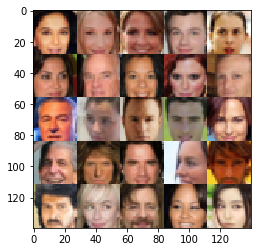

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def LeakyReLU(inputs, alpha=0.2):
    return tf.maximum(inputs * alpha, inputs)

def xavier_init(size, dtype, partition_info):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, dtype=dtype)

def discriminator(images, reuse=False, is_training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):

        x1 = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding="same", 
                                     activation_fn=None, weights_initializer=xavier_init)
        relu1 = LeakyReLU(x1)
        
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, stride=2, padding="same",
                                     activation_fn=None, weights_initializer=xavier_init)
        bn2 = tf.layers.batch_normalization(x2, training=is_training)
        relu2 = LeakyReLU(bn2)
        
        x3 = tf.contrib.layers.conv2d(relu2, 256, 5, stride=2, padding="same",
                                     activation_fn=None, weights_initializer=xavier_init)
        bn3 = tf.layers.batch_normalization(x3, training=is_training)
        relu3 = LeakyReLU(bn3)
        
        flat = tf.contrib.layers.flatten(relu3)
        output = tf.contrib.layers.fully_connected(flat, 1)
    
    return tf.nn.sigmoid(output), output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyReLU(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyReLU(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyReLU(x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        
        g = tf.tanh(logits) * 0.5

    return g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    D_real_out, D_real_digits = discriminator(input_real, reuse=False)
    G_model = generator(input_z, out_channel_dim, True)
    D_fake_out, D_fake_digits = discriminator(G_model, reuse=True)
    
    batch_size = input_real.get_shape().as_list()[0]
    print(batch_size)
    if batch_size is None:
        batch_size = 128
    lam = 10
    eps = tf.random_uniform([batch_size, *input_real.get_shape().as_list()[1:]], minval=0., maxval=1.)
    X_inter = eps * input_real + (1 - eps) * G_model
    grad = tf.gradients(discriminator(X_inter, reuse=True)[1], [X_inter])[0]
    
    grad_norm = tf.sqrt(tf.reduce_sum((grad) ** 2, axis=1))
    grad_pen = lam * tf.reduce_mean(grad_norm - 1.) ** 2
    

    
    D_loss = tf.reduce_mean(D_fake_digits) - tf.reduce_mean(D_real_digits) + grad_pen
    G_loss = -tf.reduce_mean(D_fake_digits)
    return D_loss, G_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

None
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    g_var = [var for var in variables if var.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss,
                                                                                            var_list=d_var)
        G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss,
                                                                                            var_list=g_var)
    """
    D_solver = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_var)
    G_solver = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_var)
    """
    return D_solver, G_solver


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
losses = []
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          save_folder=None, base_i=0, load_path=None):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_solver, g_solver = model_opt(d_loss, g_loss, lr, beta1)

    if save_folder and not os.path.exists(save_folder):
        os.mkdir(save_folder)

    with tf.Session() as sess:
        print("begin train")
        saver = tf.train.Saver()
        if load_path:
            saver.restore(sess, load_path)
        #tf.summary.FileWriter("./log/train", sess.graph)
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #for d_i in range(2):
                    # train discriminator more
                _ = sess.run(d_solver, feed_dict={input_real: batch_images, 
                                                  input_z: batch_z, 
                                                  lr: learning_rate})

                _ = sess.run(g_solver, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z,
                    lr: learning_rate
                })
                train_loss_d, train_loss_g = sess.run([d_loss, g_loss], feed_dict={
                    input_z: batch_z, input_real:batch_images
                })
                print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                     "Discriminator Loss: {:.4f} ".format(train_loss_d),
                     "Generator Loss: {:.4f}".format(train_loss_g))
                losses.append((train_loss_d, train_loss_g))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            if save_folder:
                saver.save(sess, "{}/{}_gan.ckpt".format(save_folder, epoch_i+base_i))

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

None
begin train
Epoch 1/3 Discriminator Loss: 3.5213  Generator Loss: -4.4697
Epoch 1/3 Discriminator Loss: 1.8718  Generator Loss: -4.1719
Epoch 1/3 Discriminator Loss: 1.0042  Generator Loss: -4.3506
Epoch 1/3 Discriminator Loss: -2.2766  Generator Loss: -2.5397
Epoch 1/3 Discriminator Loss: -2.6676  Generator Loss: -2.9584
Epoch 1/3 Discriminator Loss: -2.6966  Generator Loss: -4.0934
Epoch 1/3 Discriminator Loss: -1.5443  Generator Loss: -6.3160
Epoch 1/3 Discriminator Loss: -1.4019  Generator Loss: -7.2763
Epoch 1/3 Discriminator Loss: 2.3192  Generator Loss: -11.4639
Epoch 1/3 Discriminator Loss: 4.2297  Generator Loss: -13.9628
Epoch 1/3 Discriminator Loss: 4.5969  Generator Loss: -14.9591
Epoch 1/3 Discriminator Loss: 5.6990  Generator Loss: -16.0751
Epoch 1/3 Discriminator Loss: 5.9548  Generator Loss: -16.2126
Epoch 1/3 Discriminator Loss: 5.3367  Generator Loss: -15.2177
Epoch 1/3 Discriminator Loss: 4.4617  Generator Loss: -14.7361
Epoch 1/3 Discriminator Loss: 3.5290  Gen

Epoch 1/3 Discriminator Loss: 2.4091  Generator Loss: -10.9371
Epoch 1/3 Discriminator Loss: 2.4677  Generator Loss: -11.0982
Epoch 1/3 Discriminator Loss: 2.6195  Generator Loss: -11.2716
Epoch 1/3 Discriminator Loss: 2.4943  Generator Loss: -11.3170
Epoch 1/3 Discriminator Loss: 3.1745  Generator Loss: -11.7967
Epoch 1/3 Discriminator Loss: 3.2253  Generator Loss: -12.2087
Epoch 1/3 Discriminator Loss: 3.4164  Generator Loss: -12.6850
Epoch 1/3 Discriminator Loss: 3.5811  Generator Loss: -13.1517
Epoch 1/3 Discriminator Loss: 3.2285  Generator Loss: -12.7469
Epoch 1/3 Discriminator Loss: 2.4056  Generator Loss: -12.2882
Epoch 1/3 Discriminator Loss: 1.8723  Generator Loss: -12.0192
Epoch 1/3 Discriminator Loss: 1.8649  Generator Loss: -11.8331
Epoch 1/3 Discriminator Loss: 1.9160  Generator Loss: -12.3038
Epoch 1/3 Discriminator Loss: 2.8278  Generator Loss: -12.8871
Epoch 1/3 Discriminator Loss: 3.4027  Generator Loss: -13.7265
Epoch 1/3 Discriminator Loss: 3.7723  Generator Loss: -

Epoch 1/3 Discriminator Loss: 2.5091  Generator Loss: -15.9626
Epoch 1/3 Discriminator Loss: 2.7404  Generator Loss: -15.9907
Epoch 1/3 Discriminator Loss: 3.2077  Generator Loss: -16.1029
Epoch 1/3 Discriminator Loss: 3.3569  Generator Loss: -16.0278
Epoch 1/3 Discriminator Loss: 3.3023  Generator Loss: -15.8107
Epoch 1/3 Discriminator Loss: 3.5376  Generator Loss: -15.6611
Epoch 1/3 Discriminator Loss: 3.5115  Generator Loss: -15.3591
Epoch 1/3 Discriminator Loss: 3.0339  Generator Loss: -14.5317
Epoch 1/3 Discriminator Loss: 2.4751  Generator Loss: -13.9198
Epoch 1/3 Discriminator Loss: 2.1029  Generator Loss: -13.4572
Epoch 1/3 Discriminator Loss: 1.7710  Generator Loss: -12.8370
Epoch 1/3 Discriminator Loss: 1.8485  Generator Loss: -12.7203
Epoch 1/3 Discriminator Loss: 2.0747  Generator Loss: -12.9736
Epoch 1/3 Discriminator Loss: 1.4319  Generator Loss: -12.2358
Epoch 1/3 Discriminator Loss: 1.1328  Generator Loss: -12.0401
Epoch 1/3 Discriminator Loss: 1.1771  Generator Loss: -

Epoch 1/3 Discriminator Loss: 1.7721  Generator Loss: -14.3801
Epoch 1/3 Discriminator Loss: 1.7239  Generator Loss: -13.8482
Epoch 1/3 Discriminator Loss: 1.1865  Generator Loss: -13.2036
Epoch 1/3 Discriminator Loss: 1.1388  Generator Loss: -12.6410
Epoch 1/3 Discriminator Loss: 0.4130  Generator Loss: -11.6548
Epoch 1/3 Discriminator Loss: 0.2400  Generator Loss: -11.1309
Epoch 1/3 Discriminator Loss: 0.2269  Generator Loss: -10.7965
Epoch 1/3 Discriminator Loss: -0.0138  Generator Loss: -10.8306
Epoch 1/3 Discriminator Loss: 0.9937  Generator Loss: -11.1372
Epoch 1/3 Discriminator Loss: 0.7611  Generator Loss: -11.4121
Epoch 1/3 Discriminator Loss: 0.7925  Generator Loss: -11.7244
Epoch 1/3 Discriminator Loss: 1.0719  Generator Loss: -12.4040
Epoch 1/3 Discriminator Loss: 1.3876  Generator Loss: -12.7386
Epoch 1/3 Discriminator Loss: 0.9058  Generator Loss: -13.0923
Epoch 1/3 Discriminator Loss: 1.3329  Generator Loss: -13.6313
Epoch 1/3 Discriminator Loss: 1.5382  Generator Loss: 

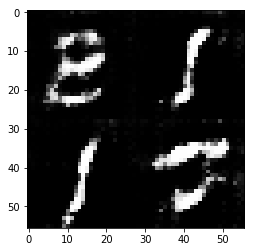

Epoch 2/3 Discriminator Loss: 0.7451  Generator Loss: -12.6652
Epoch 2/3 Discriminator Loss: 0.8127  Generator Loss: -12.5515
Epoch 2/3 Discriminator Loss: 0.7632  Generator Loss: -12.3978
Epoch 2/3 Discriminator Loss: 0.6994  Generator Loss: -12.5052
Epoch 2/3 Discriminator Loss: 0.3263  Generator Loss: -12.2272
Epoch 2/3 Discriminator Loss: 0.5550  Generator Loss: -12.1887
Epoch 2/3 Discriminator Loss: 0.0721  Generator Loss: -11.9940
Epoch 2/3 Discriminator Loss: 0.0614  Generator Loss: -11.8477
Epoch 2/3 Discriminator Loss: 0.2473  Generator Loss: -11.8016
Epoch 2/3 Discriminator Loss: 0.8928  Generator Loss: -12.1108
Epoch 2/3 Discriminator Loss: 0.4038  Generator Loss: -11.8626
Epoch 2/3 Discriminator Loss: 0.4052  Generator Loss: -11.7502
Epoch 2/3 Discriminator Loss: 0.6139  Generator Loss: -12.0136
Epoch 2/3 Discriminator Loss: 0.5651  Generator Loss: -12.2675
Epoch 2/3 Discriminator Loss: 0.8521  Generator Loss: -12.6236
Epoch 2/3 Discriminator Loss: 0.8395  Generator Loss: -

Epoch 2/3 Discriminator Loss: -0.0912  Generator Loss: -12.4206
Epoch 2/3 Discriminator Loss: -0.2644  Generator Loss: -12.3876
Epoch 2/3 Discriminator Loss: -0.2933  Generator Loss: -12.5703
Epoch 2/3 Discriminator Loss: -0.0762  Generator Loss: -12.6968
Epoch 2/3 Discriminator Loss: 0.0850  Generator Loss: -12.8065
Epoch 2/3 Discriminator Loss: 0.2494  Generator Loss: -13.0958
Epoch 2/3 Discriminator Loss: 0.4047  Generator Loss: -13.4666
Epoch 2/3 Discriminator Loss: 0.5645  Generator Loss: -13.6151
Epoch 2/3 Discriminator Loss: 0.7716  Generator Loss: -13.9818
Epoch 2/3 Discriminator Loss: 0.8333  Generator Loss: -14.2900
Epoch 2/3 Discriminator Loss: 0.8236  Generator Loss: -14.5110
Epoch 2/3 Discriminator Loss: 0.7995  Generator Loss: -14.5591
Epoch 2/3 Discriminator Loss: 0.9588  Generator Loss: -14.6628
Epoch 2/3 Discriminator Loss: 0.6905  Generator Loss: -14.3641
Epoch 2/3 Discriminator Loss: 0.1641  Generator Loss: -13.9399
Epoch 2/3 Discriminator Loss: -0.0038  Generator Lo

Epoch 2/3 Discriminator Loss: 0.8516  Generator Loss: -13.3597
Epoch 2/3 Discriminator Loss: 0.9128  Generator Loss: -13.5858
Epoch 2/3 Discriminator Loss: 0.6864  Generator Loss: -13.6570
Epoch 2/3 Discriminator Loss: 0.8729  Generator Loss: -13.9492
Epoch 2/3 Discriminator Loss: 0.5227  Generator Loss: -13.9143
Epoch 2/3 Discriminator Loss: 0.3731  Generator Loss: -13.9289
Epoch 2/3 Discriminator Loss: 0.4752  Generator Loss: -14.1413
Epoch 2/3 Discriminator Loss: 0.3661  Generator Loss: -14.1242
Epoch 2/3 Discriminator Loss: 0.3547  Generator Loss: -14.1237
Epoch 2/3 Discriminator Loss: 0.0166  Generator Loss: -14.2395
Epoch 2/3 Discriminator Loss: 0.4626  Generator Loss: -14.2343
Epoch 2/3 Discriminator Loss: 0.2672  Generator Loss: -14.3147
Epoch 2/3 Discriminator Loss: 0.6405  Generator Loss: -14.5880
Epoch 2/3 Discriminator Loss: 0.6321  Generator Loss: -14.7524
Epoch 2/3 Discriminator Loss: 0.8165  Generator Loss: -14.9352
Epoch 2/3 Discriminator Loss: 0.6567  Generator Loss: -

Epoch 2/3 Discriminator Loss: 0.6516  Generator Loss: -15.9057
Epoch 2/3 Discriminator Loss: 0.7790  Generator Loss: -15.8851
Epoch 2/3 Discriminator Loss: 0.8214  Generator Loss: -15.7358
Epoch 2/3 Discriminator Loss: 0.8507  Generator Loss: -15.6463
Epoch 2/3 Discriminator Loss: 0.8243  Generator Loss: -15.6266
Epoch 2/3 Discriminator Loss: 0.6987  Generator Loss: -15.4145
Epoch 2/3 Discriminator Loss: 0.3953  Generator Loss: -14.9909
Epoch 2/3 Discriminator Loss: 0.4841  Generator Loss: -14.8993
Epoch 2/3 Discriminator Loss: 0.1657  Generator Loss: -14.8421
Epoch 2/3 Discriminator Loss: 0.5726  Generator Loss: -14.7425
Epoch 2/3 Discriminator Loss: 0.4039  Generator Loss: -14.7354
Epoch 2/3 Discriminator Loss: 0.3470  Generator Loss: -14.6410
Epoch 2/3 Discriminator Loss: 0.2112  Generator Loss: -14.5848
Epoch 2/3 Discriminator Loss: -0.2027  Generator Loss: -14.4602
Epoch 2/3 Discriminator Loss: -0.1716  Generator Loss: -14.4565
Epoch 2/3 Discriminator Loss: -0.0977  Generator Loss

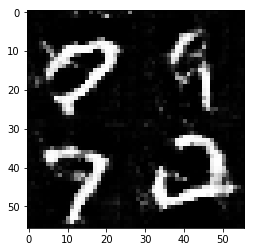

Epoch 3/3 Discriminator Loss: 0.7960  Generator Loss: -14.8315
Epoch 3/3 Discriminator Loss: 0.8102  Generator Loss: -14.9573
Epoch 3/3 Discriminator Loss: 0.6178  Generator Loss: -15.1753
Epoch 3/3 Discriminator Loss: 0.6836  Generator Loss: -15.5440
Epoch 3/3 Discriminator Loss: 0.6320  Generator Loss: -15.8015
Epoch 3/3 Discriminator Loss: 0.7821  Generator Loss: -16.2042
Epoch 3/3 Discriminator Loss: 0.4400  Generator Loss: -16.2134
Epoch 3/3 Discriminator Loss: 0.7190  Generator Loss: -16.4067
Epoch 3/3 Discriminator Loss: 0.4263  Generator Loss: -16.3803
Epoch 3/3 Discriminator Loss: 0.3911  Generator Loss: -16.3064
Epoch 3/3 Discriminator Loss: 0.3866  Generator Loss: -16.5800
Epoch 3/3 Discriminator Loss: 0.5967  Generator Loss: -16.4893
Epoch 3/3 Discriminator Loss: 0.6002  Generator Loss: -16.4304
Epoch 3/3 Discriminator Loss: 0.5541  Generator Loss: -16.0841
Epoch 3/3 Discriminator Loss: 0.4412  Generator Loss: -15.8584
Epoch 3/3 Discriminator Loss: 0.4719  Generator Loss: -

Epoch 3/3 Discriminator Loss: 0.6594  Generator Loss: -17.7232
Epoch 3/3 Discriminator Loss: 0.6074  Generator Loss: -17.7853
Epoch 3/3 Discriminator Loss: 0.0351  Generator Loss: -17.4101
Epoch 3/3 Discriminator Loss: 0.3459  Generator Loss: -17.4927
Epoch 3/3 Discriminator Loss: 0.1970  Generator Loss: -16.9906
Epoch 3/3 Discriminator Loss: 0.2524  Generator Loss: -16.9090
Epoch 3/3 Discriminator Loss: -0.1372  Generator Loss: -16.5862
Epoch 3/3 Discriminator Loss: 0.1545  Generator Loss: -16.6016
Epoch 3/3 Discriminator Loss: 0.3386  Generator Loss: -16.4936
Epoch 3/3 Discriminator Loss: 0.4972  Generator Loss: -16.5369
Epoch 3/3 Discriminator Loss: 0.4548  Generator Loss: -16.4984
Epoch 3/3 Discriminator Loss: 0.6364  Generator Loss: -16.4042
Epoch 3/3 Discriminator Loss: 0.4080  Generator Loss: -16.1898
Epoch 3/3 Discriminator Loss: 0.7565  Generator Loss: -16.3172
Epoch 3/3 Discriminator Loss: 0.5458  Generator Loss: -16.2566
Epoch 3/3 Discriminator Loss: 0.4788  Generator Loss: 

Epoch 3/3 Discriminator Loss: -0.0040  Generator Loss: -16.0654
Epoch 3/3 Discriminator Loss: 0.3763  Generator Loss: -17.0690
Epoch 3/3 Discriminator Loss: 0.5147  Generator Loss: -17.4822
Epoch 3/3 Discriminator Loss: 0.9449  Generator Loss: -17.6402
Epoch 3/3 Discriminator Loss: 0.5511  Generator Loss: -17.1170
Epoch 3/3 Discriminator Loss: 0.5388  Generator Loss: -17.1117
Epoch 3/3 Discriminator Loss: 0.6526  Generator Loss: -17.3256
Epoch 3/3 Discriminator Loss: 0.5895  Generator Loss: -17.1566
Epoch 3/3 Discriminator Loss: 0.2912  Generator Loss: -17.0695
Epoch 3/3 Discriminator Loss: 0.5200  Generator Loss: -17.1760
Epoch 3/3 Discriminator Loss: 0.3603  Generator Loss: -17.1002
Epoch 3/3 Discriminator Loss: 0.4899  Generator Loss: -17.1908
Epoch 3/3 Discriminator Loss: 0.4475  Generator Loss: -17.2467
Epoch 3/3 Discriminator Loss: 0.4535  Generator Loss: -17.2525
Epoch 3/3 Discriminator Loss: 0.3779  Generator Loss: -17.3234
Epoch 3/3 Discriminator Loss: 0.3266  Generator Loss: 

Epoch 3/3 Discriminator Loss: 0.4067  Generator Loss: -17.0348
Epoch 3/3 Discriminator Loss: 0.3256  Generator Loss: -17.0620
Epoch 3/3 Discriminator Loss: 0.4581  Generator Loss: -17.3182
Epoch 3/3 Discriminator Loss: 0.2094  Generator Loss: -17.2675
Epoch 3/3 Discriminator Loss: 0.2896  Generator Loss: -17.3579
Epoch 3/3 Discriminator Loss: 0.3153  Generator Loss: -17.5573
Epoch 3/3 Discriminator Loss: 0.3703  Generator Loss: -17.9097
Epoch 3/3 Discriminator Loss: 0.3805  Generator Loss: -18.0613
Epoch 3/3 Discriminator Loss: 0.4293  Generator Loss: -18.2942
Epoch 3/3 Discriminator Loss: 0.5098  Generator Loss: -18.5538
Epoch 3/3 Discriminator Loss: 0.6070  Generator Loss: -18.6010
Epoch 3/3 Discriminator Loss: 0.6082  Generator Loss: -18.6123
Epoch 3/3 Discriminator Loss: 0.5778  Generator Loss: -18.5980
Epoch 3/3 Discriminator Loss: 0.5934  Generator Loss: -18.4765
Epoch 3/3 Discriminator Loss: 0.3859  Generator Loss: -18.1186
Epoch 3/3 Discriminator Loss: 0.2370  Generator Loss: -

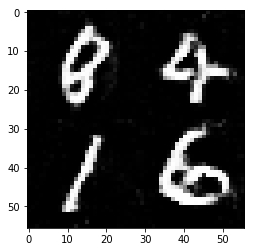

In [ ]:
batch_size = 128
z_dim = 10
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3
save_path = "mnist_save"

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, save_path)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

None
begin train
INFO:tensorflow:Restoring parameters from celeba_save/7_gan.ckpt
Epoch 1/10 Discriminator Loss: 0.2123  Generator Loss: -2.4625
Epoch 1/10 Discriminator Loss: 0.2497  Generator Loss: -2.4897
Epoch 1/10 Discriminator Loss: 0.1933  Generator Loss: -2.5132
Epoch 1/10 Discriminator Loss: 0.1742  Generator Loss: -2.5202
Epoch 1/10 Discriminator Loss: 0.1989  Generator Loss: -2.5276
Epoch 1/10 Discriminator Loss: 0.1600  Generator Loss: -2.5399
Epoch 1/10 Discriminator Loss: 0.1564  Generator Loss: -2.5624
Epoch 1/10 Discriminator Loss: 0.1489  Generator Loss: -2.5776
Epoch 1/10 Discriminator Loss: 0.2577  Generator Loss: -2.6057
Epoch 1/10 Discriminator Loss: 0.2119  Generator Loss: -2.6087
Epoch 1/10 Discriminator Loss: 0.1700  Generator Loss: -2.6314
Epoch 1/10 Discriminator Loss: 0.1426  Generator Loss: -2.6473
Epoch 1/10 Discriminator Loss: 0.1247  Generator Loss: -2.6671
Epoch 1/10 Discriminator Loss: 0.1920  Generator Loss: -2.6836
Epoch 1/10 Discriminator Loss: 0.127

Epoch 1/10 Discriminator Loss: 0.1978  Generator Loss: -2.6070
Epoch 1/10 Discriminator Loss: 0.1102  Generator Loss: -2.6101
Epoch 1/10 Discriminator Loss: 0.1037  Generator Loss: -2.6205
Epoch 1/10 Discriminator Loss: 0.1169  Generator Loss: -2.6278
Epoch 1/10 Discriminator Loss: 0.1244  Generator Loss: -2.6328
Epoch 1/10 Discriminator Loss: 0.0934  Generator Loss: -2.6047
Epoch 1/10 Discriminator Loss: 0.1634  Generator Loss: -2.6273
Epoch 1/10 Discriminator Loss: 0.1857  Generator Loss: -2.6258
Epoch 1/10 Discriminator Loss: 0.0769  Generator Loss: -2.6247
Epoch 1/10 Discriminator Loss: 0.1378  Generator Loss: -2.6366
Epoch 1/10 Discriminator Loss: 0.0758  Generator Loss: -2.6227
Epoch 1/10 Discriminator Loss: 0.0690  Generator Loss: -2.6501
Epoch 1/10 Discriminator Loss: 0.0862  Generator Loss: -2.6519
Epoch 1/10 Discriminator Loss: 0.0812  Generator Loss: -2.6637
Epoch 1/10 Discriminator Loss: 0.0867  Generator Loss: -2.6762
Epoch 1/10 Discriminator Loss: 0.1322  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1299  Generator Loss: -2.6233
Epoch 1/10 Discriminator Loss: 0.1028  Generator Loss: -2.6109
Epoch 1/10 Discriminator Loss: 0.0603  Generator Loss: -2.6442
Epoch 1/10 Discriminator Loss: 0.1487  Generator Loss: -2.6615
Epoch 1/10 Discriminator Loss: 0.0466  Generator Loss: -2.6947
Epoch 1/10 Discriminator Loss: 0.1149  Generator Loss: -2.7122
Epoch 1/10 Discriminator Loss: 0.0496  Generator Loss: -2.7305
Epoch 1/10 Discriminator Loss: 0.0931  Generator Loss: -2.7619
Epoch 1/10 Discriminator Loss: 0.0540  Generator Loss: -2.7742
Epoch 1/10 Discriminator Loss: 0.0431  Generator Loss: -2.7755
Epoch 1/10 Discriminator Loss: 0.1392  Generator Loss: -2.7900
Epoch 1/10 Discriminator Loss: 0.0457  Generator Loss: -2.8086
Epoch 1/10 Discriminator Loss: 0.2381  Generator Loss: -2.8518
Epoch 1/10 Discriminator Loss: 0.0701  Generator Loss: -2.8707
Epoch 1/10 Discriminator Loss: 0.0869  Generator Loss: -2.8711
Epoch 1/10 Discriminator Loss: 0.1667  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1853  Generator Loss: -2.8417
Epoch 1/10 Discriminator Loss: 0.1585  Generator Loss: -2.8267
Epoch 1/10 Discriminator Loss: 0.1272  Generator Loss: -2.8174
Epoch 1/10 Discriminator Loss: 0.0924  Generator Loss: -2.8362
Epoch 1/10 Discriminator Loss: 0.1846  Generator Loss: -2.8708
Epoch 1/10 Discriminator Loss: 0.1547  Generator Loss: -2.8767
Epoch 1/10 Discriminator Loss: 0.2145  Generator Loss: -2.8746
Epoch 1/10 Discriminator Loss: 0.1947  Generator Loss: -2.9166
Epoch 1/10 Discriminator Loss: 0.1614  Generator Loss: -2.8993
Epoch 1/10 Discriminator Loss: 0.2366  Generator Loss: -2.9530
Epoch 1/10 Discriminator Loss: 0.3848  Generator Loss: -2.9418
Epoch 1/10 Discriminator Loss: 0.2161  Generator Loss: -2.9243
Epoch 1/10 Discriminator Loss: 0.1833  Generator Loss: -2.9333
Epoch 1/10 Discriminator Loss: 0.2141  Generator Loss: -2.9659
Epoch 1/10 Discriminator Loss: 0.2313  Generator Loss: -2.9744
Epoch 1/10 Discriminator Loss: 0.2381  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1230  Generator Loss: -2.6205
Epoch 1/10 Discriminator Loss: 0.1264  Generator Loss: -2.6176
Epoch 1/10 Discriminator Loss: 0.1222  Generator Loss: -2.6285
Epoch 1/10 Discriminator Loss: 0.0835  Generator Loss: -2.6370
Epoch 1/10 Discriminator Loss: 0.1155  Generator Loss: -2.6471
Epoch 1/10 Discriminator Loss: 0.0491  Generator Loss: -2.6510
Epoch 1/10 Discriminator Loss: 0.0674  Generator Loss: -2.6772
Epoch 1/10 Discriminator Loss: 0.1742  Generator Loss: -2.6825
Epoch 1/10 Discriminator Loss: 0.0668  Generator Loss: -2.6998
Epoch 1/10 Discriminator Loss: 0.1273  Generator Loss: -2.7140
Epoch 1/10 Discriminator Loss: 0.1540  Generator Loss: -2.7466
Epoch 1/10 Discriminator Loss: 0.1499  Generator Loss: -2.7608
Epoch 1/10 Discriminator Loss: 0.1220  Generator Loss: -2.8205
Epoch 1/10 Discriminator Loss: 0.1273  Generator Loss: -2.8065
Epoch 1/10 Discriminator Loss: 0.2372  Generator Loss: -2.8444
Epoch 1/10 Discriminator Loss: 0.1613  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.2230  Generator Loss: -2.8178
Epoch 1/10 Discriminator Loss: 0.1866  Generator Loss: -2.8201
Epoch 1/10 Discriminator Loss: 0.2743  Generator Loss: -2.8218
Epoch 1/10 Discriminator Loss: 0.2398  Generator Loss: -2.8198
Epoch 1/10 Discriminator Loss: 0.1952  Generator Loss: -2.8145
Epoch 1/10 Discriminator Loss: 0.2259  Generator Loss: -2.8230
Epoch 1/10 Discriminator Loss: 0.1357  Generator Loss: -2.8354
Epoch 1/10 Discriminator Loss: 0.1934  Generator Loss: -2.8336
Epoch 1/10 Discriminator Loss: 0.1520  Generator Loss: -2.8236
Epoch 1/10 Discriminator Loss: 0.1790  Generator Loss: -2.8570
Epoch 1/10 Discriminator Loss: 0.1340  Generator Loss: -2.8543
Epoch 1/10 Discriminator Loss: 0.1567  Generator Loss: -2.8530
Epoch 1/10 Discriminator Loss: 0.1230  Generator Loss: -2.8887
Epoch 1/10 Discriminator Loss: 0.1610  Generator Loss: -2.8903
Epoch 1/10 Discriminator Loss: 0.3197  Generator Loss: -2.9264
Epoch 1/10 Discriminator Loss: 0.2282  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1384  Generator Loss: -2.3933
Epoch 1/10 Discriminator Loss: 1.3865  Generator Loss: -2.4158
Epoch 1/10 Discriminator Loss: 0.3198  Generator Loss: -2.4415
Epoch 1/10 Discriminator Loss: 0.2055  Generator Loss: -2.4849
Epoch 1/10 Discriminator Loss: 0.2178  Generator Loss: -2.4784
Epoch 1/10 Discriminator Loss: 0.1712  Generator Loss: -2.5091
Epoch 1/10 Discriminator Loss: 0.1533  Generator Loss: -2.5226
Epoch 1/10 Discriminator Loss: 0.1644  Generator Loss: -2.5309
Epoch 1/10 Discriminator Loss: 0.3798  Generator Loss: -2.5488
Epoch 1/10 Discriminator Loss: 0.2466  Generator Loss: -2.5680
Epoch 1/10 Discriminator Loss: 0.1637  Generator Loss: -2.5907
Epoch 1/10 Discriminator Loss: 0.4995  Generator Loss: -2.6085
Epoch 1/10 Discriminator Loss: 0.1784  Generator Loss: -2.6320
Epoch 1/10 Discriminator Loss: 0.1645  Generator Loss: -2.6411
Epoch 1/10 Discriminator Loss: 0.1346  Generator Loss: -2.6698
Epoch 1/10 Discriminator Loss: 0.1400  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1899  Generator Loss: -2.7031
Epoch 1/10 Discriminator Loss: 0.1654  Generator Loss: -2.7237
Epoch 1/10 Discriminator Loss: 0.1700  Generator Loss: -2.7373
Epoch 1/10 Discriminator Loss: 0.1647  Generator Loss: -2.7572
Epoch 1/10 Discriminator Loss: 0.1750  Generator Loss: -2.7625
Epoch 1/10 Discriminator Loss: 0.3707  Generator Loss: -2.7957
Epoch 1/10 Discriminator Loss: 0.1607  Generator Loss: -2.8003
Epoch 1/10 Discriminator Loss: 0.1427  Generator Loss: -2.7713
Epoch 1/10 Discriminator Loss: 0.3324  Generator Loss: -2.8293
Epoch 1/10 Discriminator Loss: 0.1381  Generator Loss: -2.8284
Epoch 1/10 Discriminator Loss: 0.1593  Generator Loss: -2.8453
Epoch 1/10 Discriminator Loss: 0.2310  Generator Loss: -2.8293
Epoch 1/10 Discriminator Loss: 0.1573  Generator Loss: -2.8522
Epoch 1/10 Discriminator Loss: 0.2444  Generator Loss: -2.8743
Epoch 1/10 Discriminator Loss: 0.1635  Generator Loss: -2.8736
Epoch 1/10 Discriminator Loss: 0.1311  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.2212  Generator Loss: -2.4961
Epoch 1/10 Discriminator Loss: 0.1418  Generator Loss: -2.5097
Epoch 1/10 Discriminator Loss: 0.4462  Generator Loss: -2.4833
Epoch 1/10 Discriminator Loss: 0.2758  Generator Loss: -2.4885
Epoch 1/10 Discriminator Loss: 0.1405  Generator Loss: -2.5153
Epoch 1/10 Discriminator Loss: 0.1527  Generator Loss: -2.4945
Epoch 1/10 Discriminator Loss: 0.1695  Generator Loss: -2.5100
Epoch 1/10 Discriminator Loss: 0.1406  Generator Loss: -2.5332
Epoch 1/10 Discriminator Loss: 0.1953  Generator Loss: -2.5285
Epoch 1/10 Discriminator Loss: 0.1212  Generator Loss: -2.5313
Epoch 1/10 Discriminator Loss: 0.1360  Generator Loss: -2.5641
Epoch 1/10 Discriminator Loss: 0.1425  Generator Loss: -2.5758
Epoch 1/10 Discriminator Loss: 0.1431  Generator Loss: -2.5627
Epoch 1/10 Discriminator Loss: 0.1299  Generator Loss: -2.5733
Epoch 1/10 Discriminator Loss: 0.2602  Generator Loss: -2.5659
Epoch 1/10 Discriminator Loss: 0.1502  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1791  Generator Loss: -2.5391
Epoch 1/10 Discriminator Loss: 0.1469  Generator Loss: -2.5382
Epoch 1/10 Discriminator Loss: 0.1630  Generator Loss: -2.5392
Epoch 1/10 Discriminator Loss: 0.1338  Generator Loss: -2.5274
Epoch 1/10 Discriminator Loss: 0.2932  Generator Loss: -2.5235
Epoch 1/10 Discriminator Loss: 0.1148  Generator Loss: -2.5178
Epoch 1/10 Discriminator Loss: 0.1507  Generator Loss: -2.5305
Epoch 1/10 Discriminator Loss: 0.1069  Generator Loss: -2.5044
Epoch 1/10 Discriminator Loss: 0.1377  Generator Loss: -2.5178
Epoch 1/10 Discriminator Loss: 0.1218  Generator Loss: -2.4917
Epoch 1/10 Discriminator Loss: 0.1686  Generator Loss: -2.5143
Epoch 1/10 Discriminator Loss: 0.1574  Generator Loss: -2.5395
Epoch 1/10 Discriminator Loss: 0.1102  Generator Loss: -2.5370
Epoch 1/10 Discriminator Loss: 0.1416  Generator Loss: -2.5477
Epoch 1/10 Discriminator Loss: 0.1009  Generator Loss: -2.5215
Epoch 1/10 Discriminator Loss: 0.1674  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1692  Generator Loss: -2.5840
Epoch 1/10 Discriminator Loss: 0.1170  Generator Loss: -2.6051
Epoch 1/10 Discriminator Loss: 0.3190  Generator Loss: -2.5401
Epoch 1/10 Discriminator Loss: 0.2171  Generator Loss: -2.5657
Epoch 1/10 Discriminator Loss: 0.1320  Generator Loss: -2.5421
Epoch 1/10 Discriminator Loss: 0.2384  Generator Loss: -2.5504
Epoch 1/10 Discriminator Loss: 0.2654  Generator Loss: -2.5604
Epoch 1/10 Discriminator Loss: 0.1753  Generator Loss: -2.5525
Epoch 1/10 Discriminator Loss: 0.2228  Generator Loss: -2.5782
Epoch 1/10 Discriminator Loss: 0.1569  Generator Loss: -2.5593
Epoch 1/10 Discriminator Loss: 0.1711  Generator Loss: -2.5824
Epoch 1/10 Discriminator Loss: 0.2890  Generator Loss: -2.5845
Epoch 1/10 Discriminator Loss: 0.1341  Generator Loss: -2.6026
Epoch 1/10 Discriminator Loss: 0.4954  Generator Loss: -2.6262
Epoch 1/10 Discriminator Loss: 0.0883  Generator Loss: -2.6329
Epoch 1/10 Discriminator Loss: 0.2064  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1472  Generator Loss: -2.7545
Epoch 1/10 Discriminator Loss: 0.2289  Generator Loss: -2.7782
Epoch 1/10 Discriminator Loss: 0.2119  Generator Loss: -2.7889
Epoch 1/10 Discriminator Loss: 0.2151  Generator Loss: -2.7482
Epoch 1/10 Discriminator Loss: 0.1634  Generator Loss: -2.7305
Epoch 1/10 Discriminator Loss: 0.4036  Generator Loss: -2.7146
Epoch 1/10 Discriminator Loss: 0.2679  Generator Loss: -2.6747
Epoch 1/10 Discriminator Loss: 0.1916  Generator Loss: -2.6953
Epoch 1/10 Discriminator Loss: 0.1681  Generator Loss: -2.7053
Epoch 1/10 Discriminator Loss: 0.2263  Generator Loss: -2.7019
Epoch 1/10 Discriminator Loss: 0.1135  Generator Loss: -2.6782
Epoch 1/10 Discriminator Loss: 0.1805  Generator Loss: -2.6593
Epoch 1/10 Discriminator Loss: 0.1303  Generator Loss: -2.6341
Epoch 1/10 Discriminator Loss: 0.0825  Generator Loss: -2.6070
Epoch 1/10 Discriminator Loss: 0.0758  Generator Loss: -2.5971
Epoch 1/10 Discriminator Loss: 0.1392  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.1567  Generator Loss: -2.6122
Epoch 1/10 Discriminator Loss: 0.2689  Generator Loss: -2.5850
Epoch 1/10 Discriminator Loss: 0.1190  Generator Loss: -2.5239
Epoch 1/10 Discriminator Loss: 0.1166  Generator Loss: -2.4772
Epoch 1/10 Discriminator Loss: 0.1176  Generator Loss: -2.4508
Epoch 1/10 Discriminator Loss: 0.1553  Generator Loss: -2.4232
Epoch 1/10 Discriminator Loss: 0.0983  Generator Loss: -2.3784
Epoch 1/10 Discriminator Loss: 0.0832  Generator Loss: -2.3324
Epoch 1/10 Discriminator Loss: 0.1060  Generator Loss: -2.3216
Epoch 1/10 Discriminator Loss: 0.0450  Generator Loss: -2.2501
Epoch 1/10 Discriminator Loss: 0.1123  Generator Loss: -2.1837
Epoch 1/10 Discriminator Loss: 0.1074  Generator Loss: -2.1735


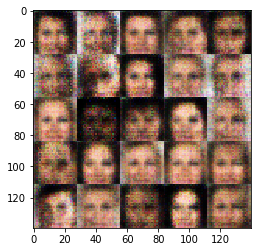

Epoch 2/10 Discriminator Loss: 0.2021  Generator Loss: -2.1875
Epoch 2/10 Discriminator Loss: 0.4887  Generator Loss: -2.2422
Epoch 2/10 Discriminator Loss: 0.3699  Generator Loss: -2.2980
Epoch 2/10 Discriminator Loss: 0.3791  Generator Loss: -2.2558
Epoch 2/10 Discriminator Loss: 0.4412  Generator Loss: -2.3386
Epoch 2/10 Discriminator Loss: 0.1566  Generator Loss: -2.2941
Epoch 2/10 Discriminator Loss: 0.5210  Generator Loss: -2.3044
Epoch 2/10 Discriminator Loss: 0.4161  Generator Loss: -2.2894
Epoch 2/10 Discriminator Loss: 0.1803  Generator Loss: -2.3115
Epoch 2/10 Discriminator Loss: 0.1790  Generator Loss: -2.3229
Epoch 2/10 Discriminator Loss: 0.1118  Generator Loss: -2.3282
Epoch 2/10 Discriminator Loss: 0.5153  Generator Loss: -2.3242
Epoch 2/10 Discriminator Loss: 0.2085  Generator Loss: -2.3361
Epoch 2/10 Discriminator Loss: 0.3378  Generator Loss: -2.3775
Epoch 2/10 Discriminator Loss: 0.1383  Generator Loss: -2.3942
Epoch 2/10 Discriminator Loss: 0.3524  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1165  Generator Loss: -2.6337
Epoch 2/10 Discriminator Loss: 0.0840  Generator Loss: -2.6307
Epoch 2/10 Discriminator Loss: 0.1123  Generator Loss: -2.6125
Epoch 2/10 Discriminator Loss: 0.0852  Generator Loss: -2.6343
Epoch 2/10 Discriminator Loss: 0.0587  Generator Loss: -2.6382
Epoch 2/10 Discriminator Loss: 0.0811  Generator Loss: -2.6344
Epoch 2/10 Discriminator Loss: 0.1688  Generator Loss: -2.6517
Epoch 2/10 Discriminator Loss: 0.1733  Generator Loss: -2.6435
Epoch 2/10 Discriminator Loss: 0.1604  Generator Loss: -2.6163
Epoch 2/10 Discriminator Loss: 0.1751  Generator Loss: -2.6311
Epoch 2/10 Discriminator Loss: 0.1242  Generator Loss: -2.6337
Epoch 2/10 Discriminator Loss: 0.4193  Generator Loss: -2.6296
Epoch 2/10 Discriminator Loss: 0.1436  Generator Loss: -2.6262
Epoch 2/10 Discriminator Loss: 0.1409  Generator Loss: -2.6112
Epoch 2/10 Discriminator Loss: 0.1103  Generator Loss: -2.6130
Epoch 2/10 Discriminator Loss: 0.1147  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1499  Generator Loss: -2.9858
Epoch 2/10 Discriminator Loss: 0.3266  Generator Loss: -2.9515
Epoch 2/10 Discriminator Loss: 0.1295  Generator Loss: -2.9545
Epoch 2/10 Discriminator Loss: 0.1855  Generator Loss: -2.9277
Epoch 2/10 Discriminator Loss: 0.1378  Generator Loss: -2.8801
Epoch 2/10 Discriminator Loss: 0.1302  Generator Loss: -2.8355
Epoch 2/10 Discriminator Loss: 0.1775  Generator Loss: -2.7933
Epoch 2/10 Discriminator Loss: 0.1897  Generator Loss: -2.7380
Epoch 2/10 Discriminator Loss: 0.3518  Generator Loss: -2.6787
Epoch 2/10 Discriminator Loss: 0.0871  Generator Loss: -2.6084
Epoch 2/10 Discriminator Loss: 0.0583  Generator Loss: -2.5725
Epoch 2/10 Discriminator Loss: 0.0083  Generator Loss: -2.5131
Epoch 2/10 Discriminator Loss: 0.0467  Generator Loss: -2.5145
Epoch 2/10 Discriminator Loss: 0.0464  Generator Loss: -2.4409
Epoch 2/10 Discriminator Loss: 0.0226  Generator Loss: -2.3886
Epoch 2/10 Discriminator Loss: 0.0303  Generator Loss: 

Epoch 2/10 Discriminator Loss: 1.8213  Generator Loss: -2.3426
Epoch 2/10 Discriminator Loss: 0.3789  Generator Loss: -2.3640
Epoch 2/10 Discriminator Loss: 1.9041  Generator Loss: -2.3379
Epoch 2/10 Discriminator Loss: 1.0425  Generator Loss: -2.3229
Epoch 2/10 Discriminator Loss: 0.3269  Generator Loss: -2.3267
Epoch 2/10 Discriminator Loss: 0.5272  Generator Loss: -2.3127
Epoch 2/10 Discriminator Loss: 0.4040  Generator Loss: -2.2896
Epoch 2/10 Discriminator Loss: 0.6874  Generator Loss: -2.3227
Epoch 2/10 Discriminator Loss: 2.7944  Generator Loss: -2.3288
Epoch 2/10 Discriminator Loss: 0.3199  Generator Loss: -2.3777
Epoch 2/10 Discriminator Loss: 0.2873  Generator Loss: -2.3640
Epoch 2/10 Discriminator Loss: 0.2043  Generator Loss: -2.3821
Epoch 2/10 Discriminator Loss: 0.2288  Generator Loss: -2.4044
Epoch 2/10 Discriminator Loss: 0.2457  Generator Loss: -2.3830
Epoch 2/10 Discriminator Loss: 0.2817  Generator Loss: -2.4267
Epoch 2/10 Discriminator Loss: 0.3845  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1539  Generator Loss: -2.5792
Epoch 2/10 Discriminator Loss: 0.1567  Generator Loss: -2.6200
Epoch 2/10 Discriminator Loss: 0.2206  Generator Loss: -2.6542
Epoch 2/10 Discriminator Loss: 0.1722  Generator Loss: -2.6967
Epoch 2/10 Discriminator Loss: 0.1207  Generator Loss: -2.7423
Epoch 2/10 Discriminator Loss: 0.1403  Generator Loss: -2.7605
Epoch 2/10 Discriminator Loss: 0.1206  Generator Loss: -2.8073
Epoch 2/10 Discriminator Loss: 0.1260  Generator Loss: -2.8320
Epoch 2/10 Discriminator Loss: 0.0840  Generator Loss: -2.8610
Epoch 2/10 Discriminator Loss: 0.2228  Generator Loss: -2.9065
Epoch 2/10 Discriminator Loss: 0.1447  Generator Loss: -2.9253
Epoch 2/10 Discriminator Loss: 0.2470  Generator Loss: -2.9790
Epoch 2/10 Discriminator Loss: 0.0684  Generator Loss: -2.9382
Epoch 2/10 Discriminator Loss: 0.2053  Generator Loss: -2.9915
Epoch 2/10 Discriminator Loss: 0.1564  Generator Loss: -3.0365
Epoch 2/10 Discriminator Loss: 0.1731  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1793  Generator Loss: -2.7191
Epoch 2/10 Discriminator Loss: 0.2026  Generator Loss: -2.7372
Epoch 2/10 Discriminator Loss: 0.1574  Generator Loss: -2.7253
Epoch 2/10 Discriminator Loss: 0.1437  Generator Loss: -2.7374
Epoch 2/10 Discriminator Loss: 0.1454  Generator Loss: -2.7405
Epoch 2/10 Discriminator Loss: 0.1399  Generator Loss: -2.7454
Epoch 2/10 Discriminator Loss: 0.1411  Generator Loss: -2.7290
Epoch 2/10 Discriminator Loss: 0.2631  Generator Loss: -2.7237
Epoch 2/10 Discriminator Loss: 0.1461  Generator Loss: -2.7260
Epoch 2/10 Discriminator Loss: 0.1329  Generator Loss: -2.7319
Epoch 2/10 Discriminator Loss: 0.1380  Generator Loss: -2.7383
Epoch 2/10 Discriminator Loss: 0.3024  Generator Loss: -2.7520
Epoch 2/10 Discriminator Loss: 0.1004  Generator Loss: -2.7398
Epoch 2/10 Discriminator Loss: 0.1991  Generator Loss: -2.7553
Epoch 2/10 Discriminator Loss: 0.1676  Generator Loss: -2.7677
Epoch 2/10 Discriminator Loss: 0.1011  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1025  Generator Loss: -2.6756
Epoch 2/10 Discriminator Loss: 0.0922  Generator Loss: -2.6626
Epoch 2/10 Discriminator Loss: 0.1412  Generator Loss: -2.6671
Epoch 2/10 Discriminator Loss: 0.1015  Generator Loss: -2.6811
Epoch 2/10 Discriminator Loss: 0.1382  Generator Loss: -2.6763
Epoch 2/10 Discriminator Loss: 0.2224  Generator Loss: -2.7018
Epoch 2/10 Discriminator Loss: 0.1329  Generator Loss: -2.7151
Epoch 2/10 Discriminator Loss: 0.1891  Generator Loss: -2.7109
Epoch 2/10 Discriminator Loss: 0.1549  Generator Loss: -2.7072
Epoch 2/10 Discriminator Loss: 0.1306  Generator Loss: -2.7162
Epoch 2/10 Discriminator Loss: 0.1814  Generator Loss: -2.7247
Epoch 2/10 Discriminator Loss: 0.1236  Generator Loss: -2.7142
Epoch 2/10 Discriminator Loss: 0.3303  Generator Loss: -2.7359
Epoch 2/10 Discriminator Loss: 0.1544  Generator Loss: -2.6982
Epoch 2/10 Discriminator Loss: 0.2265  Generator Loss: -2.7083
Epoch 2/10 Discriminator Loss: 0.1313  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.2137  Generator Loss: -2.7186
Epoch 2/10 Discriminator Loss: 0.4669  Generator Loss: -2.7399
Epoch 2/10 Discriminator Loss: 0.1288  Generator Loss: -2.7393
Epoch 2/10 Discriminator Loss: 0.5367  Generator Loss: -2.7835
Epoch 2/10 Discriminator Loss: 0.2245  Generator Loss: -2.7972
Epoch 2/10 Discriminator Loss: 0.1789  Generator Loss: -2.8121
Epoch 2/10 Discriminator Loss: 0.1583  Generator Loss: -2.8139
Epoch 2/10 Discriminator Loss: 0.2206  Generator Loss: -2.8512
Epoch 2/10 Discriminator Loss: 0.1716  Generator Loss: -2.8583
Epoch 2/10 Discriminator Loss: 0.2805  Generator Loss: -2.8549
Epoch 2/10 Discriminator Loss: 0.1570  Generator Loss: -2.8521
Epoch 2/10 Discriminator Loss: 0.1920  Generator Loss: -2.8632
Epoch 2/10 Discriminator Loss: 0.2374  Generator Loss: -2.8747
Epoch 2/10 Discriminator Loss: 0.1005  Generator Loss: -2.8820
Epoch 2/10 Discriminator Loss: 0.1089  Generator Loss: -2.8764
Epoch 2/10 Discriminator Loss: 0.1480  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1734  Generator Loss: -2.6559
Epoch 2/10 Discriminator Loss: 0.1170  Generator Loss: -2.6497
Epoch 2/10 Discriminator Loss: 0.1603  Generator Loss: -2.6635
Epoch 2/10 Discriminator Loss: 0.1862  Generator Loss: -2.6704
Epoch 2/10 Discriminator Loss: 0.1468  Generator Loss: -2.6990
Epoch 2/10 Discriminator Loss: 0.1102  Generator Loss: -2.7236
Epoch 2/10 Discriminator Loss: 0.1067  Generator Loss: -2.7412
Epoch 2/10 Discriminator Loss: 0.0676  Generator Loss: -2.7492
Epoch 2/10 Discriminator Loss: 0.2607  Generator Loss: -2.7732
Epoch 2/10 Discriminator Loss: 0.2605  Generator Loss: -2.7870
Epoch 2/10 Discriminator Loss: 0.1069  Generator Loss: -2.7874
Epoch 2/10 Discriminator Loss: 0.3080  Generator Loss: -2.8298
Epoch 2/10 Discriminator Loss: 0.1789  Generator Loss: -2.8538
Epoch 2/10 Discriminator Loss: 0.1699  Generator Loss: -2.8695
Epoch 2/10 Discriminator Loss: 0.1426  Generator Loss: -2.8767
Epoch 2/10 Discriminator Loss: 0.3232  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.2351  Generator Loss: -3.1257
Epoch 2/10 Discriminator Loss: 0.4415  Generator Loss: -3.1009
Epoch 2/10 Discriminator Loss: 0.1679  Generator Loss: -3.0857
Epoch 2/10 Discriminator Loss: 0.2498  Generator Loss: -3.1063
Epoch 2/10 Discriminator Loss: 0.1836  Generator Loss: -3.0677
Epoch 2/10 Discriminator Loss: 0.2045  Generator Loss: -3.0381
Epoch 2/10 Discriminator Loss: 0.1806  Generator Loss: -3.0176
Epoch 2/10 Discriminator Loss: 0.3470  Generator Loss: -2.9891
Epoch 2/10 Discriminator Loss: 0.2398  Generator Loss: -2.9572
Epoch 2/10 Discriminator Loss: 0.1633  Generator Loss: -2.8736
Epoch 2/10 Discriminator Loss: 0.2605  Generator Loss: -2.8435
Epoch 2/10 Discriminator Loss: 0.1229  Generator Loss: -2.8105
Epoch 2/10 Discriminator Loss: 0.2332  Generator Loss: -2.8000
Epoch 2/10 Discriminator Loss: 0.1224  Generator Loss: -2.7409
Epoch 2/10 Discriminator Loss: 0.1105  Generator Loss: -2.6957
Epoch 2/10 Discriminator Loss: 0.1000  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1932  Generator Loss: -3.0873
Epoch 2/10 Discriminator Loss: 0.2383  Generator Loss: -3.0594
Epoch 2/10 Discriminator Loss: 0.3788  Generator Loss: -3.0106
Epoch 2/10 Discriminator Loss: 0.2637  Generator Loss: -2.9825
Epoch 2/10 Discriminator Loss: 0.2002  Generator Loss: -2.9215
Epoch 2/10 Discriminator Loss: 0.3037  Generator Loss: -2.8751
Epoch 2/10 Discriminator Loss: 0.1752  Generator Loss: -2.8297
Epoch 2/10 Discriminator Loss: 0.1424  Generator Loss: -2.7688
Epoch 2/10 Discriminator Loss: 0.1936  Generator Loss: -2.7462
Epoch 2/10 Discriminator Loss: 0.2471  Generator Loss: -2.7163
Epoch 2/10 Discriminator Loss: 0.1755  Generator Loss: -2.6629
Epoch 2/10 Discriminator Loss: 0.1766  Generator Loss: -2.6178
Epoch 2/10 Discriminator Loss: 0.2426  Generator Loss: -2.5779
Epoch 2/10 Discriminator Loss: 0.2427  Generator Loss: -2.5254
Epoch 2/10 Discriminator Loss: 0.1410  Generator Loss: -2.4723
Epoch 2/10 Discriminator Loss: 0.5577  Generator Loss: 

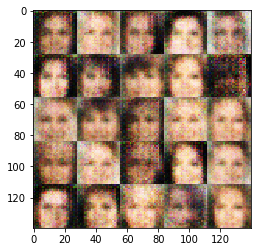

Epoch 3/10 Discriminator Loss: 0.1781  Generator Loss: -2.6698
Epoch 3/10 Discriminator Loss: 0.1534  Generator Loss: -2.6596
Epoch 3/10 Discriminator Loss: 0.2388  Generator Loss: -2.6427
Epoch 3/10 Discriminator Loss: 0.1860  Generator Loss: -2.6014
Epoch 3/10 Discriminator Loss: 0.1476  Generator Loss: -2.5867
Epoch 3/10 Discriminator Loss: 0.2213  Generator Loss: -2.5400
Epoch 3/10 Discriminator Loss: 0.1352  Generator Loss: -2.5221
Epoch 3/10 Discriminator Loss: 0.1129  Generator Loss: -2.4601
Epoch 3/10 Discriminator Loss: 0.1101  Generator Loss: -2.4382
Epoch 3/10 Discriminator Loss: 0.0889  Generator Loss: -2.4297
Epoch 3/10 Discriminator Loss: 0.0866  Generator Loss: -2.3797
Epoch 3/10 Discriminator Loss: 0.0828  Generator Loss: -2.3344
Epoch 3/10 Discriminator Loss: 0.0576  Generator Loss: -2.3214
Epoch 3/10 Discriminator Loss: 0.0873  Generator Loss: -2.2894
Epoch 3/10 Discriminator Loss: 0.0860  Generator Loss: -2.2749
Epoch 3/10 Discriminator Loss: 0.0486  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.2527  Generator Loss: -2.9581
Epoch 3/10 Discriminator Loss: 0.2775  Generator Loss: -2.9609
Epoch 3/10 Discriminator Loss: 0.1283  Generator Loss: -2.9343
Epoch 3/10 Discriminator Loss: 0.0972  Generator Loss: -2.9493
Epoch 3/10 Discriminator Loss: 0.1988  Generator Loss: -2.9468
Epoch 3/10 Discriminator Loss: 0.1211  Generator Loss: -2.9340
Epoch 3/10 Discriminator Loss: 0.1412  Generator Loss: -2.9214
Epoch 3/10 Discriminator Loss: 0.2965  Generator Loss: -2.8859
Epoch 3/10 Discriminator Loss: 0.5998  Generator Loss: -2.8659
Epoch 3/10 Discriminator Loss: 0.1239  Generator Loss: -2.8596
Epoch 3/10 Discriminator Loss: 0.3184  Generator Loss: -2.8481
Epoch 3/10 Discriminator Loss: 0.4041  Generator Loss: -2.8183
Epoch 3/10 Discriminator Loss: 0.1474  Generator Loss: -2.7810
Epoch 3/10 Discriminator Loss: 0.1304  Generator Loss: -2.7528
Epoch 3/10 Discriminator Loss: 0.1493  Generator Loss: -2.7396
Epoch 3/10 Discriminator Loss: 0.1226  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1966  Generator Loss: -3.0725
Epoch 3/10 Discriminator Loss: 0.2425  Generator Loss: -3.0768
Epoch 3/10 Discriminator Loss: 0.1096  Generator Loss: -3.0551
Epoch 3/10 Discriminator Loss: 0.1109  Generator Loss: -3.0644
Epoch 3/10 Discriminator Loss: 0.1818  Generator Loss: -3.0801
Epoch 3/10 Discriminator Loss: 0.2537  Generator Loss: -3.0751
Epoch 3/10 Discriminator Loss: 0.1955  Generator Loss: -3.0779
Epoch 3/10 Discriminator Loss: 0.2382  Generator Loss: -3.0497
Epoch 3/10 Discriminator Loss: 0.1506  Generator Loss: -3.0373
Epoch 3/10 Discriminator Loss: 0.1397  Generator Loss: -3.0290
Epoch 3/10 Discriminator Loss: 0.1660  Generator Loss: -3.0342
Epoch 3/10 Discriminator Loss: 0.1638  Generator Loss: -2.9988
Epoch 3/10 Discriminator Loss: 0.1497  Generator Loss: -2.9999
Epoch 3/10 Discriminator Loss: 0.2215  Generator Loss: -2.9543
Epoch 3/10 Discriminator Loss: 0.1420  Generator Loss: -2.9329
Epoch 3/10 Discriminator Loss: 0.1440  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1649  Generator Loss: -2.6629
Epoch 3/10 Discriminator Loss: 0.1479  Generator Loss: -2.7524
Epoch 3/10 Discriminator Loss: 0.2545  Generator Loss: -2.7534
Epoch 3/10 Discriminator Loss: 0.1990  Generator Loss: -2.7896
Epoch 3/10 Discriminator Loss: 0.2335  Generator Loss: -2.7706
Epoch 3/10 Discriminator Loss: 0.1910  Generator Loss: -2.8044
Epoch 3/10 Discriminator Loss: 0.9109  Generator Loss: -2.8169
Epoch 3/10 Discriminator Loss: 0.2006  Generator Loss: -2.8082
Epoch 3/10 Discriminator Loss: 0.2213  Generator Loss: -2.8174
Epoch 3/10 Discriminator Loss: 0.1444  Generator Loss: -2.8324
Epoch 3/10 Discriminator Loss: 0.1397  Generator Loss: -2.8365
Epoch 3/10 Discriminator Loss: 0.2271  Generator Loss: -2.8566
Epoch 3/10 Discriminator Loss: 0.1529  Generator Loss: -2.8591
Epoch 3/10 Discriminator Loss: 0.3273  Generator Loss: -2.8482
Epoch 3/10 Discriminator Loss: 0.1531  Generator Loss: -2.8649
Epoch 3/10 Discriminator Loss: 0.1111  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1165  Generator Loss: -2.8447
Epoch 3/10 Discriminator Loss: 0.1609  Generator Loss: -2.8384
Epoch 3/10 Discriminator Loss: 0.1218  Generator Loss: -2.8458
Epoch 3/10 Discriminator Loss: 0.1269  Generator Loss: -2.8766
Epoch 3/10 Discriminator Loss: 0.1367  Generator Loss: -2.9177
Epoch 3/10 Discriminator Loss: 0.0975  Generator Loss: -2.9422
Epoch 3/10 Discriminator Loss: 0.1394  Generator Loss: -2.9569
Epoch 3/10 Discriminator Loss: 0.1145  Generator Loss: -2.9951
Epoch 3/10 Discriminator Loss: 0.1480  Generator Loss: -3.0322
Epoch 3/10 Discriminator Loss: 0.1441  Generator Loss: -3.0094
Epoch 3/10 Discriminator Loss: 0.1864  Generator Loss: -3.0281
Epoch 3/10 Discriminator Loss: 0.2465  Generator Loss: -3.0226
Epoch 3/10 Discriminator Loss: 0.1502  Generator Loss: -3.0377
Epoch 3/10 Discriminator Loss: 0.1832  Generator Loss: -3.0213
Epoch 3/10 Discriminator Loss: 0.1728  Generator Loss: -3.0247
Epoch 3/10 Discriminator Loss: 0.1727  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1392  Generator Loss: -2.8695
Epoch 3/10 Discriminator Loss: 0.1346  Generator Loss: -2.8496
Epoch 3/10 Discriminator Loss: 0.1071  Generator Loss: -2.8134
Epoch 3/10 Discriminator Loss: 0.1442  Generator Loss: -2.8214
Epoch 3/10 Discriminator Loss: 0.1197  Generator Loss: -2.7678
Epoch 3/10 Discriminator Loss: 0.0845  Generator Loss: -2.7272
Epoch 3/10 Discriminator Loss: 0.0996  Generator Loss: -2.7331
Epoch 3/10 Discriminator Loss: 0.2523  Generator Loss: -2.6857
Epoch 3/10 Discriminator Loss: 0.0986  Generator Loss: -2.6966
Epoch 3/10 Discriminator Loss: 0.1833  Generator Loss: -2.6841
Epoch 3/10 Discriminator Loss: 0.1274  Generator Loss: -2.7113
Epoch 3/10 Discriminator Loss: 0.1348  Generator Loss: -2.7028
Epoch 3/10 Discriminator Loss: 0.1574  Generator Loss: -2.7250
Epoch 3/10 Discriminator Loss: 0.1321  Generator Loss: -2.7194
Epoch 3/10 Discriminator Loss: 0.1902  Generator Loss: -2.7166
Epoch 3/10 Discriminator Loss: 0.1617  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1405  Generator Loss: -2.4312
Epoch 3/10 Discriminator Loss: 0.1294  Generator Loss: -2.4319
Epoch 3/10 Discriminator Loss: 0.0804  Generator Loss: -2.4083
Epoch 3/10 Discriminator Loss: 0.5706  Generator Loss: -2.3952
Epoch 3/10 Discriminator Loss: 0.4464  Generator Loss: -2.4448
Epoch 3/10 Discriminator Loss: 0.2508  Generator Loss: -2.3907
Epoch 3/10 Discriminator Loss: 0.6244  Generator Loss: -2.4419
Epoch 3/10 Discriminator Loss: 0.2383  Generator Loss: -2.3957
Epoch 3/10 Discriminator Loss: 0.1891  Generator Loss: -2.4478
Epoch 3/10 Discriminator Loss: 0.2210  Generator Loss: -2.4061
Epoch 3/10 Discriminator Loss: 0.3232  Generator Loss: -2.4719
Epoch 3/10 Discriminator Loss: 0.2111  Generator Loss: -2.4540
Epoch 3/10 Discriminator Loss: 0.2714  Generator Loss: -2.5104
Epoch 3/10 Discriminator Loss: 0.2954  Generator Loss: -2.5347
Epoch 3/10 Discriminator Loss: 0.8185  Generator Loss: -2.5555
Epoch 3/10 Discriminator Loss: 0.1777  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.4190  Generator Loss: -2.4999
Epoch 3/10 Discriminator Loss: 0.2271  Generator Loss: -2.5244
Epoch 3/10 Discriminator Loss: 0.3209  Generator Loss: -2.5521
Epoch 3/10 Discriminator Loss: 0.1710  Generator Loss: -2.5611
Epoch 3/10 Discriminator Loss: 0.1734  Generator Loss: -2.5539
Epoch 3/10 Discriminator Loss: 0.1686  Generator Loss: -2.5604
Epoch 3/10 Discriminator Loss: 0.2016  Generator Loss: -2.5845
Epoch 3/10 Discriminator Loss: 0.1790  Generator Loss: -2.5991
Epoch 3/10 Discriminator Loss: 0.4006  Generator Loss: -2.6091
Epoch 3/10 Discriminator Loss: 0.1645  Generator Loss: -2.6223
Epoch 3/10 Discriminator Loss: 0.1717  Generator Loss: -2.6476
Epoch 3/10 Discriminator Loss: 0.1681  Generator Loss: -2.6593
Epoch 3/10 Discriminator Loss: 0.2080  Generator Loss: -2.6811
Epoch 3/10 Discriminator Loss: 0.2567  Generator Loss: -2.7136
Epoch 3/10 Discriminator Loss: 0.1346  Generator Loss: -2.7276
Epoch 3/10 Discriminator Loss: 0.1788  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1062  Generator Loss: -2.5387
Epoch 3/10 Discriminator Loss: 0.1120  Generator Loss: -2.5512
Epoch 3/10 Discriminator Loss: 0.1291  Generator Loss: -2.5807
Epoch 3/10 Discriminator Loss: 0.1873  Generator Loss: -2.5747
Epoch 3/10 Discriminator Loss: 0.1634  Generator Loss: -2.5938
Epoch 3/10 Discriminator Loss: 0.1573  Generator Loss: -2.6077
Epoch 3/10 Discriminator Loss: 0.1138  Generator Loss: -2.6081
Epoch 3/10 Discriminator Loss: 0.2107  Generator Loss: -2.6409
Epoch 3/10 Discriminator Loss: 0.1919  Generator Loss: -2.6563
Epoch 3/10 Discriminator Loss: 0.1386  Generator Loss: -2.6595
Epoch 3/10 Discriminator Loss: 0.1655  Generator Loss: -2.6743
Epoch 3/10 Discriminator Loss: 0.1175  Generator Loss: -2.6914
Epoch 3/10 Discriminator Loss: 0.1206  Generator Loss: -2.7104
Epoch 3/10 Discriminator Loss: 0.2210  Generator Loss: -2.7278
Epoch 3/10 Discriminator Loss: 0.1389  Generator Loss: -2.7443
Epoch 3/10 Discriminator Loss: 0.1083  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1393  Generator Loss: -2.7059
Epoch 3/10 Discriminator Loss: 0.0787  Generator Loss: -2.7089
Epoch 3/10 Discriminator Loss: 0.2487  Generator Loss: -2.6943
Epoch 3/10 Discriminator Loss: 0.0743  Generator Loss: -2.6973
Epoch 3/10 Discriminator Loss: 0.1488  Generator Loss: -2.7012
Epoch 3/10 Discriminator Loss: 0.1044  Generator Loss: -2.7030
Epoch 3/10 Discriminator Loss: 0.1222  Generator Loss: -2.6960
Epoch 3/10 Discriminator Loss: 0.1441  Generator Loss: -2.6627
Epoch 3/10 Discriminator Loss: 0.1148  Generator Loss: -2.6907
Epoch 3/10 Discriminator Loss: 0.1431  Generator Loss: -2.6651
Epoch 3/10 Discriminator Loss: 0.1414  Generator Loss: -2.7122
Epoch 3/10 Discriminator Loss: 0.1444  Generator Loss: -2.7193
Epoch 3/10 Discriminator Loss: 0.1375  Generator Loss: -2.7069
Epoch 3/10 Discriminator Loss: 0.2331  Generator Loss: -2.7125
Epoch 3/10 Discriminator Loss: 0.1229  Generator Loss: -2.6827
Epoch 3/10 Discriminator Loss: 0.1431  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.0391  Generator Loss: -2.6235
Epoch 3/10 Discriminator Loss: 0.0744  Generator Loss: -2.6141
Epoch 3/10 Discriminator Loss: 0.0767  Generator Loss: -2.5717
Epoch 3/10 Discriminator Loss: 0.1727  Generator Loss: -2.5865
Epoch 3/10 Discriminator Loss: 0.0841  Generator Loss: -2.5868
Epoch 3/10 Discriminator Loss: 0.0521  Generator Loss: -2.5658
Epoch 3/10 Discriminator Loss: 0.0400  Generator Loss: -2.5618
Epoch 3/10 Discriminator Loss: 0.1863  Generator Loss: -2.5143
Epoch 3/10 Discriminator Loss: 0.0744  Generator Loss: -2.5518
Epoch 3/10 Discriminator Loss: 0.1049  Generator Loss: -2.5771
Epoch 3/10 Discriminator Loss: 0.1486  Generator Loss: -2.5608
Epoch 3/10 Discriminator Loss: 0.1478  Generator Loss: -2.5454
Epoch 3/10 Discriminator Loss: 0.2366  Generator Loss: -2.6194
Epoch 3/10 Discriminator Loss: 0.1765  Generator Loss: -2.6048
Epoch 3/10 Discriminator Loss: 0.1100  Generator Loss: -2.6123
Epoch 3/10 Discriminator Loss: 0.0987  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1444  Generator Loss: -2.6982
Epoch 3/10 Discriminator Loss: 0.1482  Generator Loss: -2.6647
Epoch 3/10 Discriminator Loss: 0.1504  Generator Loss: -2.6869
Epoch 3/10 Discriminator Loss: 0.1946  Generator Loss: -2.6807
Epoch 3/10 Discriminator Loss: 0.2708  Generator Loss: -2.6774
Epoch 3/10 Discriminator Loss: 0.1193  Generator Loss: -2.6403
Epoch 3/10 Discriminator Loss: 0.1416  Generator Loss: -2.6690
Epoch 3/10 Discriminator Loss: 0.1326  Generator Loss: -2.6895
Epoch 3/10 Discriminator Loss: 0.1239  Generator Loss: -2.6835
Epoch 3/10 Discriminator Loss: 0.1323  Generator Loss: -2.6782
Epoch 3/10 Discriminator Loss: 0.1285  Generator Loss: -2.6801
Epoch 3/10 Discriminator Loss: 0.1106  Generator Loss: -2.6969
Epoch 3/10 Discriminator Loss: 0.0871  Generator Loss: -2.6905
Epoch 3/10 Discriminator Loss: 0.0738  Generator Loss: -2.6889
Epoch 3/10 Discriminator Loss: 0.1047  Generator Loss: -2.6909
Epoch 3/10 Discriminator Loss: 0.0453  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1572  Generator Loss: -3.0128
Epoch 4/10 Discriminator Loss: 0.1171  Generator Loss: -2.9643
Epoch 4/10 Discriminator Loss: 0.1101  Generator Loss: -2.9234
Epoch 4/10 Discriminator Loss: 0.0754  Generator Loss: -2.8736
Epoch 4/10 Discriminator Loss: 0.1167  Generator Loss: -2.8556
Epoch 4/10 Discriminator Loss: 0.1062  Generator Loss: -2.8139
Epoch 4/10 Discriminator Loss: 0.0899  Generator Loss: -2.8011
Epoch 4/10 Discriminator Loss: 0.0924  Generator Loss: -2.7779
Epoch 4/10 Discriminator Loss: 0.0506  Generator Loss: -2.7186
Epoch 4/10 Discriminator Loss: 0.0426  Generator Loss: -2.6924
Epoch 4/10 Discriminator Loss: 0.0768  Generator Loss: -2.6376
Epoch 4/10 Discriminator Loss: 0.0535  Generator Loss: -2.6052
Epoch 4/10 Discriminator Loss: 0.1021  Generator Loss: -2.5821
Epoch 4/10 Discriminator Loss: -0.0036  Generator Loss: -2.5126
Epoch 4/10 Discriminator Loss: -0.0247  Generator Loss: -2.4618
Epoch 4/10 Discriminator Loss: 0.0375  Generator Loss

Epoch 4/10 Discriminator Loss: 0.1611  Generator Loss: -2.9143
Epoch 4/10 Discriminator Loss: 0.1481  Generator Loss: -2.9020
Epoch 4/10 Discriminator Loss: 0.1862  Generator Loss: -2.8760
Epoch 4/10 Discriminator Loss: 0.2031  Generator Loss: -2.8349
Epoch 4/10 Discriminator Loss: 0.2447  Generator Loss: -2.7956
Epoch 4/10 Discriminator Loss: 0.1252  Generator Loss: -2.7664
Epoch 4/10 Discriminator Loss: 0.1111  Generator Loss: -2.7440
Epoch 4/10 Discriminator Loss: 0.2058  Generator Loss: -2.6992
Epoch 4/10 Discriminator Loss: 0.1634  Generator Loss: -2.6604
Epoch 4/10 Discriminator Loss: 0.0863  Generator Loss: -2.6224
Epoch 4/10 Discriminator Loss: 0.1128  Generator Loss: -2.6187
Epoch 4/10 Discriminator Loss: 0.3725  Generator Loss: -2.5966
Epoch 4/10 Discriminator Loss: 0.0687  Generator Loss: -2.5814
Epoch 4/10 Discriminator Loss: 0.0495  Generator Loss: -2.5468
Epoch 4/10 Discriminator Loss: 0.0993  Generator Loss: -2.5417
Epoch 4/10 Discriminator Loss: 0.0985  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1235  Generator Loss: -2.9653
Epoch 4/10 Discriminator Loss: 0.1167  Generator Loss: -2.9770
Epoch 4/10 Discriminator Loss: 0.1002  Generator Loss: -2.9732
Epoch 4/10 Discriminator Loss: 0.0824  Generator Loss: -2.9612
Epoch 4/10 Discriminator Loss: 0.0915  Generator Loss: -2.9427
Epoch 4/10 Discriminator Loss: 0.0889  Generator Loss: -2.9339
Epoch 4/10 Discriminator Loss: 0.1170  Generator Loss: -2.9459
Epoch 4/10 Discriminator Loss: 0.1379  Generator Loss: -2.9272
Epoch 4/10 Discriminator Loss: 0.1443  Generator Loss: -2.9066
Epoch 4/10 Discriminator Loss: 0.1366  Generator Loss: -2.8739
Epoch 4/10 Discriminator Loss: 0.1311  Generator Loss: -2.8503
Epoch 4/10 Discriminator Loss: 0.1690  Generator Loss: -2.8749
Epoch 4/10 Discriminator Loss: 0.2211  Generator Loss: -2.8414
Epoch 4/10 Discriminator Loss: 0.1580  Generator Loss: -2.8116
Epoch 4/10 Discriminator Loss: 0.1412  Generator Loss: -2.8030
Epoch 4/10 Discriminator Loss: 0.1294  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.0944  Generator Loss: -2.6777
Epoch 4/10 Discriminator Loss: 0.1376  Generator Loss: -2.6839
Epoch 4/10 Discriminator Loss: 0.1704  Generator Loss: -2.7106
Epoch 4/10 Discriminator Loss: 0.1475  Generator Loss: -2.6975
Epoch 4/10 Discriminator Loss: 0.2384  Generator Loss: -2.7118
Epoch 4/10 Discriminator Loss: 0.1827  Generator Loss: -2.6843
Epoch 4/10 Discriminator Loss: 0.1665  Generator Loss: -2.7058
Epoch 4/10 Discriminator Loss: 0.1893  Generator Loss: -2.7229
Epoch 4/10 Discriminator Loss: 0.1808  Generator Loss: -2.7335
Epoch 4/10 Discriminator Loss: 0.2215  Generator Loss: -2.7114
Epoch 4/10 Discriminator Loss: 0.1628  Generator Loss: -2.7442
Epoch 4/10 Discriminator Loss: 0.1466  Generator Loss: -2.7592
Epoch 4/10 Discriminator Loss: 0.1529  Generator Loss: -2.7564
Epoch 4/10 Discriminator Loss: 0.1687  Generator Loss: -2.7284
Epoch 4/10 Discriminator Loss: 0.1298  Generator Loss: -2.7318
Epoch 4/10 Discriminator Loss: 0.1704  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.0978  Generator Loss: -2.5747
Epoch 4/10 Discriminator Loss: 0.2568  Generator Loss: -2.5712
Epoch 4/10 Discriminator Loss: 0.2425  Generator Loss: -2.5739
Epoch 4/10 Discriminator Loss: 0.1773  Generator Loss: -2.5887
Epoch 4/10 Discriminator Loss: 0.1949  Generator Loss: -2.5642
Epoch 4/10 Discriminator Loss: 0.1571  Generator Loss: -2.5610
Epoch 4/10 Discriminator Loss: 0.1020  Generator Loss: -2.5169
Epoch 4/10 Discriminator Loss: 0.1334  Generator Loss: -2.5563
Epoch 4/10 Discriminator Loss: 0.1017  Generator Loss: -2.5620
Epoch 4/10 Discriminator Loss: 0.1218  Generator Loss: -2.5633
Epoch 4/10 Discriminator Loss: 0.0669  Generator Loss: -2.5560
Epoch 4/10 Discriminator Loss: 0.1540  Generator Loss: -2.5810
Epoch 4/10 Discriminator Loss: 0.0719  Generator Loss: -2.5816
Epoch 4/10 Discriminator Loss: 0.1819  Generator Loss: -2.6081
Epoch 4/10 Discriminator Loss: 0.0809  Generator Loss: -2.6357
Epoch 4/10 Discriminator Loss: 0.0309  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1407  Generator Loss: -2.5652
Epoch 4/10 Discriminator Loss: 0.0383  Generator Loss: -2.5312
Epoch 4/10 Discriminator Loss: 0.0790  Generator Loss: -2.5738
Epoch 4/10 Discriminator Loss: 0.1587  Generator Loss: -2.5858
Epoch 4/10 Discriminator Loss: 0.0662  Generator Loss: -2.6149
Epoch 4/10 Discriminator Loss: 0.0571  Generator Loss: -2.6304
Epoch 4/10 Discriminator Loss: 0.1295  Generator Loss: -2.6859
Epoch 4/10 Discriminator Loss: 0.0069  Generator Loss: -2.6560
Epoch 4/10 Discriminator Loss: 0.0619  Generator Loss: -2.7191
Epoch 4/10 Discriminator Loss: 0.0626  Generator Loss: -2.7552
Epoch 4/10 Discriminator Loss: 0.0942  Generator Loss: -2.7943
Epoch 4/10 Discriminator Loss: 0.0811  Generator Loss: -2.8141
Epoch 4/10 Discriminator Loss: 0.1007  Generator Loss: -2.8497
Epoch 4/10 Discriminator Loss: 0.1416  Generator Loss: -2.8999
Epoch 4/10 Discriminator Loss: 0.1385  Generator Loss: -2.9171
Epoch 4/10 Discriminator Loss: 0.1330  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1196  Generator Loss: -2.8639
Epoch 4/10 Discriminator Loss: 0.1936  Generator Loss: -2.8924
Epoch 4/10 Discriminator Loss: 0.0840  Generator Loss: -2.9105
Epoch 4/10 Discriminator Loss: 0.0927  Generator Loss: -2.9193
Epoch 4/10 Discriminator Loss: 0.1440  Generator Loss: -2.9348
Epoch 4/10 Discriminator Loss: 0.1687  Generator Loss: -2.9466
Epoch 4/10 Discriminator Loss: 0.1410  Generator Loss: -2.9632
Epoch 4/10 Discriminator Loss: 0.1888  Generator Loss: -2.9864
Epoch 4/10 Discriminator Loss: 0.1594  Generator Loss: -2.9781
Epoch 4/10 Discriminator Loss: 0.1302  Generator Loss: -2.9764
Epoch 4/10 Discriminator Loss: 0.1908  Generator Loss: -2.9890
Epoch 4/10 Discriminator Loss: 0.1443  Generator Loss: -2.9685
Epoch 4/10 Discriminator Loss: 0.1960  Generator Loss: -2.9672
Epoch 4/10 Discriminator Loss: 0.1075  Generator Loss: -2.9903
Epoch 4/10 Discriminator Loss: 0.1638  Generator Loss: -2.9787
Epoch 4/10 Discriminator Loss: 0.0867  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1590  Generator Loss: -3.0536
Epoch 4/10 Discriminator Loss: 0.0688  Generator Loss: -3.0596
Epoch 4/10 Discriminator Loss: 0.0766  Generator Loss: -3.0602
Epoch 4/10 Discriminator Loss: 0.0791  Generator Loss: -3.0337
Epoch 4/10 Discriminator Loss: 0.0880  Generator Loss: -3.0200
Epoch 4/10 Discriminator Loss: 0.1484  Generator Loss: -3.0566
Epoch 4/10 Discriminator Loss: 0.1357  Generator Loss: -3.0167
Epoch 4/10 Discriminator Loss: 0.1189  Generator Loss: -3.0007
Epoch 4/10 Discriminator Loss: 0.1305  Generator Loss: -2.9880
Epoch 4/10 Discriminator Loss: 0.1335  Generator Loss: -2.9804
Epoch 4/10 Discriminator Loss: 0.1154  Generator Loss: -2.9505
Epoch 4/10 Discriminator Loss: 0.0934  Generator Loss: -2.9383
Epoch 4/10 Discriminator Loss: 0.0703  Generator Loss: -2.9120
Epoch 4/10 Discriminator Loss: 0.0835  Generator Loss: -2.9015
Epoch 4/10 Discriminator Loss: 0.0724  Generator Loss: -2.8810
Epoch 4/10 Discriminator Loss: 0.0859  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1241  Generator Loss: -2.9515
Epoch 4/10 Discriminator Loss: 0.1664  Generator Loss: -2.9709
Epoch 4/10 Discriminator Loss: 0.1037  Generator Loss: -2.9700
Epoch 4/10 Discriminator Loss: 0.1135  Generator Loss: -2.9489
Epoch 4/10 Discriminator Loss: 0.1171  Generator Loss: -2.9492
Epoch 4/10 Discriminator Loss: 0.1010  Generator Loss: -2.9493
Epoch 4/10 Discriminator Loss: 0.1153  Generator Loss: -2.9269
Epoch 4/10 Discriminator Loss: 0.0997  Generator Loss: -2.9270
Epoch 4/10 Discriminator Loss: 0.0954  Generator Loss: -2.9293
Epoch 4/10 Discriminator Loss: 0.0850  Generator Loss: -2.9288
Epoch 4/10 Discriminator Loss: 0.0988  Generator Loss: -2.9309
Epoch 4/10 Discriminator Loss: 0.1288  Generator Loss: -2.9046
Epoch 4/10 Discriminator Loss: 0.1799  Generator Loss: -2.9104
Epoch 4/10 Discriminator Loss: 0.0975  Generator Loss: -2.9172
Epoch 4/10 Discriminator Loss: 0.1217  Generator Loss: -2.9319
Epoch 4/10 Discriminator Loss: 0.0912  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1482  Generator Loss: -2.8212
Epoch 4/10 Discriminator Loss: 0.0907  Generator Loss: -2.8325
Epoch 4/10 Discriminator Loss: 0.1558  Generator Loss: -2.8614
Epoch 4/10 Discriminator Loss: 0.1609  Generator Loss: -2.8405
Epoch 4/10 Discriminator Loss: 0.1766  Generator Loss: -2.8813
Epoch 4/10 Discriminator Loss: 0.1304  Generator Loss: -2.8878
Epoch 4/10 Discriminator Loss: 0.1003  Generator Loss: -2.8935
Epoch 4/10 Discriminator Loss: 0.1104  Generator Loss: -2.9217
Epoch 4/10 Discriminator Loss: 0.1000  Generator Loss: -2.9211
Epoch 4/10 Discriminator Loss: 0.1025  Generator Loss: -2.9587
Epoch 4/10 Discriminator Loss: 0.2143  Generator Loss: -2.9715
Epoch 4/10 Discriminator Loss: 0.1530  Generator Loss: -2.9847
Epoch 4/10 Discriminator Loss: 0.1901  Generator Loss: -2.9992
Epoch 4/10 Discriminator Loss: 0.1028  Generator Loss: -3.0248
Epoch 4/10 Discriminator Loss: 0.0639  Generator Loss: -3.0162
Epoch 4/10 Discriminator Loss: 0.0808  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1315  Generator Loss: -2.8726
Epoch 4/10 Discriminator Loss: 0.1407  Generator Loss: -2.8873
Epoch 4/10 Discriminator Loss: 0.0916  Generator Loss: -2.9120
Epoch 4/10 Discriminator Loss: 0.2429  Generator Loss: -2.9647
Epoch 4/10 Discriminator Loss: 0.0945  Generator Loss: -2.9716
Epoch 4/10 Discriminator Loss: 0.1150  Generator Loss: -2.9996
Epoch 4/10 Discriminator Loss: 0.1173  Generator Loss: -2.9926
Epoch 4/10 Discriminator Loss: 0.2261  Generator Loss: -3.0102
Epoch 4/10 Discriminator Loss: 0.1768  Generator Loss: -3.0260
Epoch 4/10 Discriminator Loss: 0.1538  Generator Loss: -3.0256
Epoch 4/10 Discriminator Loss: 0.1172  Generator Loss: -3.0523
Epoch 4/10 Discriminator Loss: 0.1593  Generator Loss: -3.0183
Epoch 4/10 Discriminator Loss: 0.1026  Generator Loss: -2.9979
Epoch 4/10 Discriminator Loss: 0.1062  Generator Loss: -3.0452
Epoch 4/10 Discriminator Loss: 0.1178  Generator Loss: -3.0314
Epoch 4/10 Discriminator Loss: 0.0695  Generator Loss: 

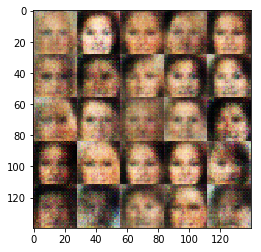

Epoch 5/10 Discriminator Loss: 0.1235  Generator Loss: -2.5627
Epoch 5/10 Discriminator Loss: 0.2175  Generator Loss: -2.5823
Epoch 5/10 Discriminator Loss: 0.0946  Generator Loss: -2.5955
Epoch 5/10 Discriminator Loss: 0.0905  Generator Loss: -2.6091
Epoch 5/10 Discriminator Loss: 0.1340  Generator Loss: -2.6152
Epoch 5/10 Discriminator Loss: 0.1641  Generator Loss: -2.6077
Epoch 5/10 Discriminator Loss: 0.1933  Generator Loss: -2.6166
Epoch 5/10 Discriminator Loss: 0.1665  Generator Loss: -2.6146
Epoch 5/10 Discriminator Loss: 0.1721  Generator Loss: -2.6206
Epoch 5/10 Discriminator Loss: 0.1443  Generator Loss: -2.6465
Epoch 5/10 Discriminator Loss: 0.1361  Generator Loss: -2.6534
Epoch 5/10 Discriminator Loss: 0.1474  Generator Loss: -2.6280
Epoch 5/10 Discriminator Loss: 0.1350  Generator Loss: -2.6457
Epoch 5/10 Discriminator Loss: 0.1499  Generator Loss: -2.6654
Epoch 5/10 Discriminator Loss: 0.1066  Generator Loss: -2.6519
Epoch 5/10 Discriminator Loss: 0.1776  Generator Loss: 

Epoch 5/10 Discriminator Loss: 0.0830  Generator Loss: -2.6579
Epoch 5/10 Discriminator Loss: 0.0887  Generator Loss: -2.6520
Epoch 5/10 Discriminator Loss: 0.0915  Generator Loss: -2.6391
Epoch 5/10 Discriminator Loss: 0.1323  Generator Loss: -2.6325
Epoch 5/10 Discriminator Loss: 0.1029  Generator Loss: -2.6229
Epoch 5/10 Discriminator Loss: 0.0486  Generator Loss: -2.5819
Epoch 5/10 Discriminator Loss: 0.1259  Generator Loss: -2.5818
Epoch 5/10 Discriminator Loss: 0.1429  Generator Loss: -2.5762
Epoch 5/10 Discriminator Loss: 0.2330  Generator Loss: -2.6067
Epoch 5/10 Discriminator Loss: 0.1634  Generator Loss: -2.5994
Epoch 5/10 Discriminator Loss: 0.3333  Generator Loss: -2.5882
Epoch 5/10 Discriminator Loss: 0.0462  Generator Loss: -2.5780
Epoch 5/10 Discriminator Loss: 0.0171  Generator Loss: -2.5440
Epoch 5/10 Discriminator Loss: 0.1742  Generator Loss: -2.6027
Epoch 5/10 Discriminator Loss: 0.0815  Generator Loss: -2.6358
Epoch 5/10 Discriminator Loss: 0.1348  Generator Loss: 

Epoch 5/10 Discriminator Loss: 0.1202  Generator Loss: -2.9153
Epoch 5/10 Discriminator Loss: 0.0854  Generator Loss: -2.9005
Epoch 5/10 Discriminator Loss: 0.0807  Generator Loss: -2.9059
Epoch 5/10 Discriminator Loss: 0.0904  Generator Loss: -2.8899
Epoch 5/10 Discriminator Loss: 0.1028  Generator Loss: -2.8823
Epoch 5/10 Discriminator Loss: 0.0652  Generator Loss: -2.8519
Epoch 5/10 Discriminator Loss: 0.1025  Generator Loss: -2.8436
Epoch 5/10 Discriminator Loss: 0.0786  Generator Loss: -2.8264
Epoch 5/10 Discriminator Loss: 0.1178  Generator Loss: -2.8381
Epoch 5/10 Discriminator Loss: 0.1267  Generator Loss: -2.7842
Epoch 5/10 Discriminator Loss: 0.1779  Generator Loss: -2.7408
Epoch 5/10 Discriminator Loss: 0.2031  Generator Loss: -2.7490
Epoch 5/10 Discriminator Loss: 0.0785  Generator Loss: -2.7351
Epoch 5/10 Discriminator Loss: 0.2006  Generator Loss: -2.7360
Epoch 5/10 Discriminator Loss: 0.1307  Generator Loss: -2.7051
Epoch 5/10 Discriminator Loss: 0.0860  Generator Loss: 

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10
save_path = "celeba_save"


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 
          save_folder=save_path, base_i=8, load_path=save_path+"/7_gan.ckpt")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.